In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from eelbrain import *

In [2]:
#load the dataset
print('load EEG dataset. May take some time')
data = []
scores = np.zeros((21,1394,1394))
for subj in range(21):
    tmp = []
    dataSub = loadmat(f"datasetCND_musicImagery/musicImagery/dataCND/dataSub{subj+1}.mat")
    for n in range(88):
        tmp.append(dataSub['eeg']['data'][0,0][0,n].T)
    data.append(np.asarray(tmp))
    
data = np.asarray(data)


chorals = np.asarray([i//11 for i in range(44)])
confusion = np.zeros((21, len(set(chorals)), len(set(chorals))))
met = loadmat('datasetCND_musicImagery/musicImagery/dataCND/metronome.mat')
met = met['met']
idx_met = np.where(met[:,0] != 0)[0]

for imet in idx_met:
    data[:,:,:,imet:imet+34] = 0

a_ma = np.ma.masked_equal(data,0)
data = np.array([i.compressed() for i in a_ma]).reshape(21,88,64,1803 - 34*len(idx_met))
print('Done!')

load EEG dataset. May take some time
Done!


In [3]:
%run Model.py
r_model = []
r_null = []
import warnings
warnings.filterwarnings('ignore')
for test_sbj_idx in range(0,21):
    print(f'Subject test: {test_sbj_idx+1}')
    model = Lis2Img().to(device) # reset the weights for each experiments
    model.to(dtype=torch.double)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    
    train_sbjs_idx = list(range(21))
    train_sbjs_idx.remove(test_sbj_idx)
    
    train_sbjs = data[train_sbjs_idx,:,:,:1394]#:1802]
    test_sbj = data[test_sbj_idx,:,:,:1394]#:1802]
    
    # (1) make data to pre-train the model as and AE for 20 subjects (all data from 20 sbjs)
    # (2) fix the encoder train the decoder part for lis_to_img (devide into train and test)
    # (3) test the network for the left-out sbj (all data from left_out sbjs)
    
    data_tr = train_sbjs.reshape(20*88,64,1394)                     #(1)
    data_lis = train_sbjs[:,:44,:,:].reshape(20*44,64,1394)         #(2a)
    data_img = train_sbjs[:,-44:,:,:].reshape(20*44,64,1394)        #(2b)
    tst_sbj_lis = test_sbj[:44,:,:]                                 #(3a)
    tst_sbj_img = test_sbj[-44:,:,:]                                #(3b)
    
    [all_train, all_test] = random_split(data_tr, [1700, 60],        #(1)
                                         generator=torch.Generator().manual_seed(42)) 
    
    [lis_train, lis_test] = random_split(data_lis, [800, 80],       #(2)
                                 generator=torch.Generator().manual_seed(42))
    [img_train, img_test] = random_split(data_img, [800, 80],        #(2))
                                 generator=torch.Generator().manual_seed(42))
    
    
    # Create dataloaders
    batch_size = 4
    all_train_dataloader = DataLoader(all_train, batch_size=batch_size)
    all_test_dataloader = DataLoader(all_test, batch_size=batch_size)
    
    lis_train_dataloader = DataLoader(lis_train, batch_size=batch_size)
    lis_test_dataloader = DataLoader(lis_test, batch_size=batch_size)
    img_train_dataloader = DataLoader(img_train, batch_size=batch_size)
    img_test_dataloader = DataLoader(img_test, batch_size=batch_size)
    
    

    epochs = 30
    print("[[Pre-training autoencoder]]")
    for t in tqdm_notebook(range(epochs), leave=True, desc = f'{epochs} Epochs'):
        if t == epochs-1:
            print_result = True
        else:
            print_result = False
        # print(f"Epoch {t+1}\n-------------------------------")
        train(all_train_dataloader, all_train_dataloader, model, loss_fn, optimizer)
        test(all_test_dataloader, all_test_dataloader, model, loss_fn, print_result)
        
    
    print("[[Fix decoder weights]]")
    model.encoder.requires_grad_(False)  
    epochs = 30
    for t in tqdm_notebook(range(epochs), leave=True, desc = f'{epochs} Epochs'):
        train(lis_train_dataloader, img_train_dataloader, model, loss_fn, optimizer)
        test(lis_test_dataloader, img_test_dataloader, model, loss_fn)
    
    
    ###### lis2img for the unseen subject
    [test_sbj_lis, _] = random_split(tst_sbj_lis, [44, 0], generator=torch.Generator().manual_seed(42))
    [test_sbj_img, _] = random_split(tst_sbj_img, [44, 0], generator=torch.Generator().manual_seed(42))
    test_lis = DataLoader(test_sbj_lis, batch_size=batch_size)
    test_img = DataLoader(test_sbj_img, batch_size=batch_size)
    print(f'Test the network on Subject: {test_sbj_idx + 1}')
    test(test_lis, test_img, model, loss_fn, print_result = False)    
    
    X = torch.tensor(test_sbj_lis)
    Y = torch.tensor(test_sbj_img)
    Pred = model(X).detach()
    tmp = R_value(Y,Pred)
    r_model.append(np.asarray(tmp))
    save.pickle(np.asarray(Pred), f'Pred_img/sbj{test_sbj_idx}_Pred.pkl')
    
    ###### lis2img for Null model
    [test_sbj_lis, _] = random_split(tst_sbj_lis, [44, 0], generator=torch.Generator().manual_seed(4))
    [test_sbj_img, _] = random_split(tst_sbj_img, [44, 0], generator=torch.Generator().manual_seed(42))
    test_lis = DataLoader(test_sbj_lis, batch_size=batch_size)
    test_img = DataLoader(test_sbj_img, batch_size=batch_size)
    print(f'Test the network on CONTROL Subject: {test_sbj_idx + 1}')
    test(test_lis, test_img, model, loss_fn, print_result = False)
        
    X = torch.tensor(test_sbj_lis)
    Y = torch.tensor(test_sbj_img)
    Pred = model(X).detach()
    tmp = R_value(Y,Pred)
    r_null.append(np.asarray(tmp))
r_model, r_null = np.mean(np.array(r_model),2), np.mean(np.array(r_null),2)
print('Finished All Experiments')

Using cpu device
Subject test: 1
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 41469.97953719109
	Avg R value: 0.7439300963337613

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 1
Test the network on CONTROL Subject: 1
Subject test: 2
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 43814.55361959825
	Avg R value: 0.7364953628451008

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 2
Test the network on CONTROL Subject: 2
Subject test: 3
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 39830.728848078565
	Avg R value: 0.7465195507019996

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 3
Test the network on CONTROL Subject: 3
Subject test: 4
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 40898.89433002631
	Avg R value: 0.752095197334211

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 4
Test the network on CONTROL Subject: 4
Subject test: 5
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 39174.38265059169
	Avg R value: 0.7563535844573579

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 5
Test the network on CONTROL Subject: 5
Subject test: 6
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 39951.193138442264
	Avg R value: 0.7343072063969759

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 6
Test the network on CONTROL Subject: 6
Subject test: 7
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 37600.4842085862
	Avg R value: 0.7409656708028081

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 7
Test the network on CONTROL Subject: 7
Subject test: 8
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 39358.53961474903
	Avg R value: 0.7288200122320398

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 8
Test the network on CONTROL Subject: 8
Subject test: 9
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 36891.90803968721
	Avg R value: 0.7423812280893431

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 9
Test the network on CONTROL Subject: 9
Subject test: 10
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 37972.60644746507
	Avg R value: 0.7506942861007533

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 10
Test the network on CONTROL Subject: 10
Subject test: 11
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 38855.61339621678
	Avg R value: 0.7328903159953414

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 11
Test the network on CONTROL Subject: 11
Subject test: 12
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 38465.39642866742
	Avg R value: 0.7463026557150254

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 12
Test the network on CONTROL Subject: 12
Subject test: 13
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 36357.63375120277
	Avg R value: 0.7390872892566309

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 13
Test the network on CONTROL Subject: 13
Subject test: 14
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 36711.51553621398
	Avg R value: 0.7418292591487117

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 14
Test the network on CONTROL Subject: 14
Subject test: 15
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 37464.00480194918
	Avg R value: 0.7448578170275696

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 15
Test the network on CONTROL Subject: 15
Subject test: 16
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 38626.74638231049
	Avg R value: 0.7313570186679372

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 16
Test the network on CONTROL Subject: 16
Subject test: 17
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 38842.384493369835
	Avg R value: 0.7341382017849211

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 17
Test the network on CONTROL Subject: 17
Subject test: 18
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 41860.83178365455
	Avg R value: 0.7168612658229212

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 18
Test the network on CONTROL Subject: 18
Subject test: 19
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 30433.492728562207
	Avg R value: 0.7915512054531088

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 19
Test the network on CONTROL Subject: 19
Subject test: 20
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 39508.839087560336
	Avg R value: 0.7149668910772139

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 20
Test the network on CONTROL Subject: 20
Subject test: 21
[[Pre-training autoencoder]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test:
	Avg loss: 38378.22669426092
	Avg R value: 0.6984713841155653

[[Fix decoder weights]]


30 Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test the network on Subject: 21
Test the network on CONTROL Subject: 21
Finished All Experiments


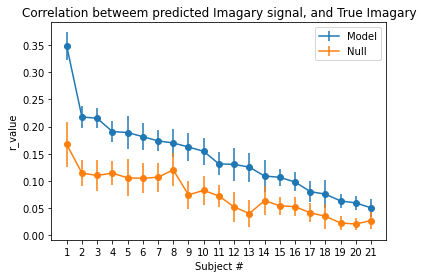

In [20]:
##PLot the Performance of the DNN model against the Null fore each subjects

idx = np.argsort(r_model.mean(1))
idx = idx[::-1]
fig, ax = plt.subplots(1)
im = ax.scatter(np.arange(1,22,1),r_model[idx,:].mean(axis = 1))
ax.errorbar(np.arange(1,22,1),r_model[idx,:].mean(axis = 1),
             yerr=r_model[idx,:].std(axis = 1)/np.sqrt(21),  label = 'Model')
ax.scatter(np.arange(1,22,1),r_null[idx,:].mean(axis = 1))
ax.errorbar(np.arange(1,22,1),r_null[idx,:].mean(axis = 1),
             yerr=r_null[idx,:].std(axis = 1)/np.sqrt(21), label = 'Null')
ax.xaxis.set_ticks(np.arange(1, 22, step=1))
ax.set_xlabel('Subject #')
ax.set_ylabel('r_value')
ax.set_title('Correlation betweem predicted Imagary signal, and True Imagary')
ax.legend()